In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
from collections import deque
import numpy as np
import os

In [3]:
def getBlocks(img):
    blocks = []
    (m, n) = img.shape
    
    for i in range(m // 8):
        for j in range(n // 8):
            blocks.append(img[8*i:8*i+8,8*j:8*j+8])
            
    return blocks

def quantizeBlocks(block):
    quant_mat = np.array([[16,11,10,16,24,40,51,61],
                          [12,12,14,19,26,58,60,55],
                          [14,13,16,24,40,57,69,56],
                          [14,17,22,29,51,87,80,62],
                          [18,22,37,56,68,109,103,77],
                          [24,35,55,64,81,104,113,92],
                          [49,64,78,87,103,121,120,101],
                          [72,92,95,98,112,100,103,99]])
    
    round_block = np.round(block / quant_mat)
    return round_block

def zigzag(block):
    coeff = []
    i = 0
    j = 1
    direc = 1
    direc2 = 1
    
    while i != 7 or j != 7:
        coeff.append(block[i,j])
        
        if i == 7 and j == 0:
            direc2 = -direc2
        
        if direc2 == 1:
            if direc == -1 and i == 0:
                j = j+1
                direc = -direc
            elif direc == 1 and j == 0:
                i = i+1
                direc = -direc
            else:
                if direc == 1:
                    i = i+1
                    j = j-1
                else:
                    j = j+1
                    i = i-1
        else:
            if direc == 1 and i == 7:
                j = j+1
                direc = -direc
            elif direc == -1 and j == 7:
                i = i+1
                direc = -direc
            else:
                if direc == 1:
                    i = i+1
                    j = j-1
                else:
                    j = j+1
                    i = i-1
                
    return coeff

def jDCenc(blocks):
    enc = []
    base = 0
    
    for i in range(len(blocks)):
        coeff = blocks[i][0,0] - base
        enc.append(coeff)
        base = blocks[i][0,0]
        
    return enc

def jACenc(coeff):
    enc = []
    run = 0
    
    for i in range(len(coeff)):
        if coeff[i] == 0:
            run = run+1
            continue
        
        enc.append((run, coeff[i]))
        run = 0
        
    if run != 0:
        enc.append((0, 0))
        
    return enc

def MyJPEGEncoder(img, filename):
    # Convert image to numpy
    img = np.array(img, dtype='float64')
    
    # Subtract offset
    img = img - 128
    
    # Get blocks
    blocks = getBlocks(img)
    
    # Perform DCT
    dct_blocks = [cv2.dct(block) for block in blocks]
    
    # Quantize blocks
    rounded_blocks = [quantizeBlocks(block) for block in dct_blocks]
    
    # ZigZag scanning
    ac_coeff = [zigzag(block) for block in rounded_blocks]
    
    # DC Encoded values
    dc_enc = jDCenc(rounded_blocks)
    
    # AC encoded values
    ac_enc = [jACenc(coeff) for coeff in ac_coeff]
    
    # Write to file
    f = open(filename, "a")
    dc = ','.join([str(int(i)) for i in dc_enc]) + '\n'
    ac_str = []
    for ac_e in ac_enc:
        ac_str.append(' '.join([str(int(i[0])) + ',' + str(int(i[1])) for i in ac_e]))
    ac = '\n'.join(ac_str)
    f.write(dc)
    f.write(ac)
    f.close()
    
    return ac_enc, dc_enc

In [4]:
def combineBlocks(blocks, size):
    (m, n) = size
    x = m // 8
    img = np.zeros((m, n), dtype='float64')
    
    for i in range(len(blocks)):
        img[8*(i//x):8*(i//x)+8, 8*(i%x):8*(i%x)+8] = blocks[i]
            
    return img

def rescaleBlocks(block):
    quant_mat = np.array([[16,11,10,16,24,40,51,61],
                          [12,12,14,19,26,58,60,55],
                          [14,13,16,24,40,57,69,56],
                          [14,17,22,29,51,87,80,62],
                          [18,22,37,56,68,109,103,77],
                          [24,35,55,64,81,104,113,92],
                          [49,64,78,87,103,121,120,101],
                          [72,92,95,98,112,100,103,99]])
    
    rescaled_block = block * quant_mat
    return rescaled_block

def izigzag(enc):
    block = np.zeros((8, 8), dtype='float64')
    i = 0
    j = 1
    k = 0 # index for encoded length
    direc = 1
    direc2 = 1
    
    while i != 7 or j != 7:
        block[i, j] = enc[k]
        k = k+1
        
        if i == 7 and j == 0:
            direc2 = -direc2
        
        if direc2 == 1:
            if direc == -1 and i == 0:
                j = j+1
                direc = -direc
            elif direc == 1 and j == 0:
                i = i+1
                direc = -direc
            else:
                if direc == 1:
                    i = i+1
                    j = j-1
                else:
                    j = j+1
                    i = i-1
        else:
            if direc == 1 and i == 7:
                j = j+1
                direc = -direc
            elif direc == -1 and j == 7:
                i = i+1
                direc = -direc
            else:
                if direc == 1:
                    i = i+1
                    j = j-1
                else:
                    j = j+1
                    i = i-1
                
    return block

def jDCdec(dc_enc):
    dec = []
    base = 0
    
    for i in range(len(dc_enc)):
        val = dc_enc[i] + base
        dec.append(val)
        base = val
        
    return dec

def jACdec(enc):
    dec = []
    
    for i in range(len(enc)):
        for j in range(enc[i][0]):
            dec.append(0)
        
        dec.append(enc[i][1])
        
    rem = 63 - len(dec)
    for i in range(rem):
        dec.append(0)
        
    return dec

def MyJPEGDecoder(size, ac_enc, dc_enc):
    # Decode AC coeff
    ac_coeff = [jACdec(ac_e) for ac_e in ac_enc]
    
    # Decode DC coeff
    dc_coeff = jDCdec(dc_enc)
    
    # ZigZag Exapansion
    blocks_enc = [izigzag(ac_co) for ac_co in ac_coeff]
    
    ## Add DC components back to original place
    for i in range(len(dc_coeff)):
        blocks_enc[i][0, 0] = dc_coeff[i]
    
    # Rescale blocks
    rescaled_blocks = [rescaleBlocks(block) for block in blocks_enc]
    
    # IDCT
    blocks = [cv2.idct(block) for block in rescaled_blocks]
    
    # Reconstruction
    img = combineBlocks(blocks, size)
    
    # Offset
    img = img + 128
    
    return img

In [5]:
lena = Image.open('img/Lena512.gif').convert('L')
Img1 = Image.open('img/Img1.tiff').convert('L')
Img2 = Image.open('img/Img2.tiff').convert('L')

In [6]:
lout = MyJPEGEncoder(lena, "compressed/Lena512.RLE")
i1out = MyJPEGEncoder(Img1, "compressed/Img1.RLE")
i2out = MyJPEGEncoder(Img2, "compressed/Img2.RLE")

In [7]:
ldec = MyJPEGDecoder((512, 512), lout[0], lout[1])
i1dec = MyJPEGDecoder((256, 256), i1out[0], i1out[1])
i2dec = MyJPEGDecoder((1024, 1024), i2out[0], i2out[1])

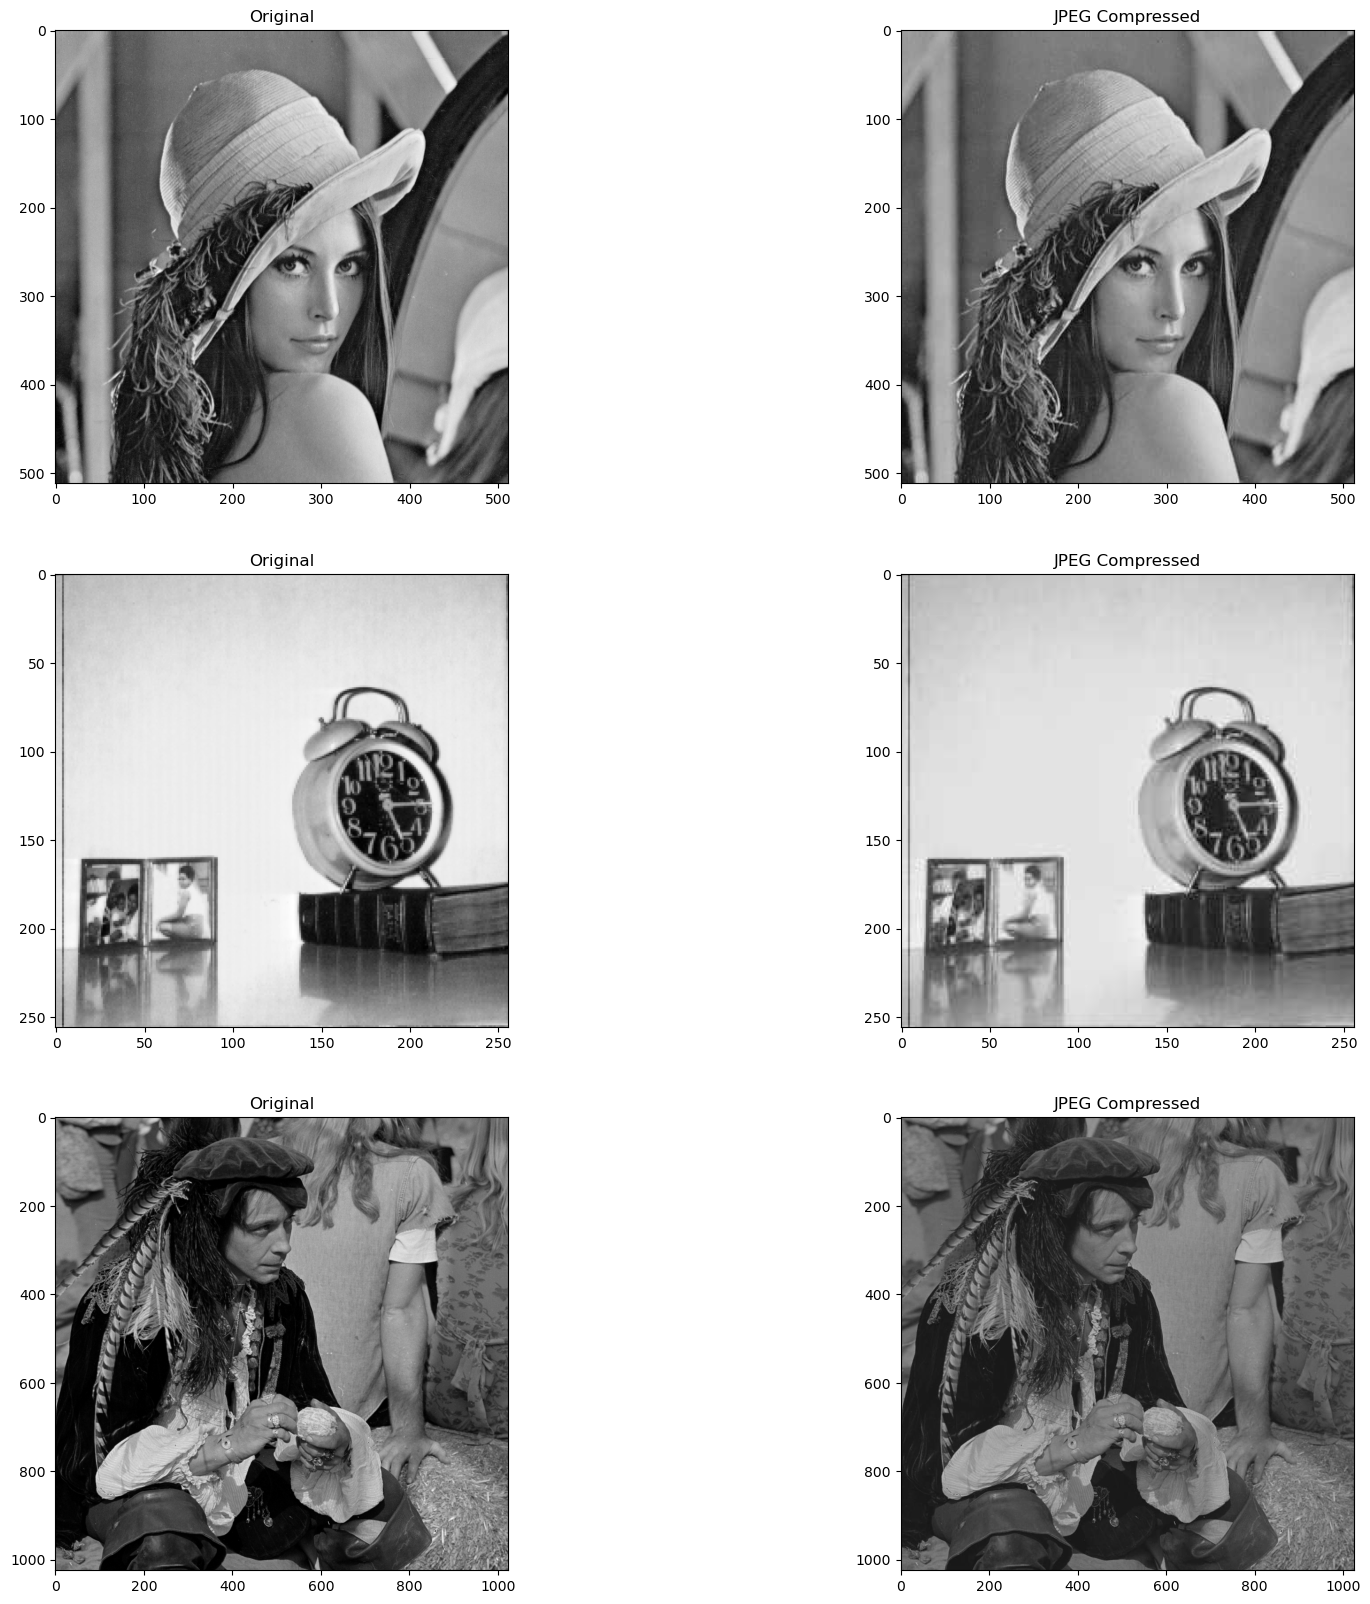

In [8]:
plt.figure(figsize=(20,20))

plt.subplot(3, 2, 1)
plt.title('Original')
plt.imshow(lena, cmap='gray')
plt.subplot(3, 2, 2)
plt.title('JPEG Compressed')
plt.imshow(ldec, cmap='gray')

plt.subplot(3, 2, 3)
plt.title('Original')
plt.imshow(Img1, cmap='gray')
plt.subplot(3, 2, 4)
plt.title('JPEG Compressed')
plt.imshow(i1dec, cmap='gray')

plt.subplot(3, 2, 5)
plt.title('Original')
plt.imshow(Img2, cmap='gray')
plt.subplot(3, 2, 6)
plt.title('JPEG Compressed')
plt.imshow(i2dec, cmap='gray')

plt.show()

In [9]:
lcomp = os.path.getsize('img/Lena512.gif') / os.path.getsize("compressed/Lena512.RLE")
i1comp = os.path.getsize('img/Img1.tiff') / os.path.getsize("compressed/Img1.RLE")
i2comp = os.path.getsize('img/Img2.tiff') / os.path.getsize("compressed/Img2.RLE")

print("Lena compression:", lcomp)
print("Img1 compression:", i1comp)
print("Img2 compression:", i2comp)

Lena compression: 1.8448141227654293
Img1 compression: 1.8891318105977792
Img2 compression: 1.435757088700657
